# Part 1: Data Loading and Preprocesssing

In [1]:
from pyspark.sql import SparkSession

# Initializing Spark session
spark = SparkSession.builder \
    .appName("NYC Taxi Trip Analysis") \
    .getOrCreate()

# Loading the dataset into a DataFrame and showing only top 5 rows
df = spark.read.parquet("/content/drive/MyDrive/yellow_tripdata_2024-06.parquet")
df.show(5)


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2024-06-01 00:03:46|  2024-06-01 00:31:23|              1|         12.5|         1|                 N|         138|         195|           1|       48.5| 7.75|    0.5|     11.5

In [2]:
from pyspark.sql.functions import col

# Removing duplicates records
df_cleaned = df.dropDuplicates()

# Filtering out records with unrealistic values and showing top 5 rows
df_filtered = df_cleaned.filter(
    (col("fare_amount") > 0) &
    (col("passenger_count") > 0)
)
df_filtered.show(5)


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2024-06-01 00:58:27|  2024-06-01 01:04:16|              1|         1.45|         1|                 N|         142|         246|           1|        9.3|  1.0|    0.5|      2.8

#Part 2 - Exploratory Data Analysis:

*Summary*

The busiest day for NYC taxi trips is **Saturday**, with demand peaking at **6 PM**, while most trips have an average fare of around **$20** and cover a distance of **7.78 miles** with 1-2 passengers.



In [4]:
#Part 2: Exploratory Data Analysis using  DataFrames

#Computing statistical summaries for fare amount, trip distance and passenger count and showing top 5 rows
df_filtered.select(
    "fare_amount", "trip_distance", "passenger_count"
).describe().show()


+-------+-----------------+------------------+------------------+
|summary|      fare_amount|     trip_distance|   passenger_count|
+-------+-----------------+------------------+------------------+
|  count|          3043196|           3043196|           3043196|
|   mean|19.97992295599995|3.7767924642381603|1.3525964150846677|
| stddev|20.39202588119038| 171.7576534794265|0.8147315899270339|
|    min|             0.01|               0.0|                 1|
|    max|          12898.4|          154096.9|                 9|
+-------+-----------------+------------------+------------------+



In [7]:
from pyspark.sql.functions import dayofweek, hour, desc

# Adding day of week and hour columns
df_time = df_filtered.withColumn("day_of_week", dayofweek("tpep_pickup_datetime")) \
                     .withColumn("hour_of_day", hour("tpep_pickup_datetime"))

# Busiest days of the week
df_time.groupBy("day_of_week").count().orderBy(desc("count")).show()

# Busiest hours of the day
df_time.groupBy("hour_of_day").count().orderBy(desc("count")).show()


+-----------+------+
|day_of_week| count|
+-----------+------+
|          7|502702|
|          5|455343|
|          4|435104|
|          3|433429|
|          1|419134|
|          6|417982|
|          2|379502|
+-----------+------+

+-----------+------+
|hour_of_day| count|
+-----------+------+
|         18|215921|
|         17|204770|
|         16|192655|
|         15|191324|
|         19|188646|
|         14|187813|
|         13|176140|
|         21|174506|
|         20|169000|
|         12|167761|
|         22|160735|
|         11|155398|
|         10|141254|
|          9|126040|
|         23|123408|
|          8|107666|
|          0| 89000|
|          7| 74985|
|          1| 59259|
|          2| 39538|
+-----------+------+
only showing top 20 rows



# Part 3 - Temporal Analysis:

*Summary Findings*

The daily analysis shows that taxi usage fluctuates throughout the month, with peaks on the **27th** and **28th**, recording over **1.1 million trips each**. The average trip distance remains relatively consistent, ranging from **2.6 to 8.7 miles** across the days.



In [8]:
from pyspark.sql.functions import dayofmonth, count, avg

# Add a day of the month column for daily trends
df_daily = df_time.withColumn("day_of_month", dayofmonth("tpep_pickup_datetime"))

# Analyze daily taxi usage trends
df_daily_trends = df_daily.groupBy("day_of_month") \
                          .agg(count("*").alias("total_trips"),
                               avg("trip_distance").alias("avg_trip_distance"))

df_daily_trends.show()


+------------+-----------+------------------+
|day_of_month|total_trips| avg_trip_distance|
+------------+-----------+------------------+
|          31|         43| 2.600232558139535|
|          28|      95125|3.6453123784494106|
|          26|     112459|3.2210148587485135|
|          27|     108532| 3.622081137360403|
|          12|     111564| 3.245716897924064|
|          22|     100318| 3.224598377160629|
|           1|     108210| 3.186531096941137|
|          13|     115703| 3.227370336119208|
|           6|     120494|3.6329396484472065|
|          16|      81479| 4.759077676456516|
|           3|      97889|3.6263790619987906|
|          20|     110612| 3.256737786135325|
|           5|     115930| 3.167979039075311|
|          19|      95151| 3.338420720749125|
|          15|      98138|3.3411250484012434|
|           9|      84524| 4.917394349533854|
|          17|      89967| 3.591025931730526|
|           4|     110254| 5.915013877047572|
|           8|     105420|3.236847

# Part 4 - Geospatial Analysis:

*Summary*

The top pickup and drop-off locations are primarily associated with location IDs **132**, **161**, and **237**, indicating high demand in these areas. The average trip distance varies significantly, with the highest average fare of **$269.71** observed for location ID **156**, suggesting longer trips and potentially different regions' characteristics affecting fares.

In [9]:
# Top pickup locations
df_filtered.groupBy("PULocationID").count().orderBy(desc("count")).show(5)

# Top drop-off locations
df_filtered.groupBy("DOLocationID").count().orderBy(desc("count")).show(5)


+------------+------+
|PULocationID| count|
+------------+------+
|         132|154235|
|         161|147065|
|         237|146196|
|         236|127483|
|         138|112764|
+------------+------+
only showing top 5 rows

+------------+------+
|DOLocationID| count|
+------------+------+
|         236|134851|
|         237|129985|
|         161|116277|
|         230|101286|
|         170| 93378|
+------------+------+
only showing top 5 rows



In [10]:
# Analyze how trip distances influence fare amounts across pickup locations
df_filtered.groupBy("PULocationID") \
           .agg(avg("trip_distance").alias("avg_distance"),
                avg("fare_amount").alias("avg_fare")) \
           .orderBy(desc("avg_fare")).show(5)


+------------+------------------+------------------+
|PULocationID|      avg_distance|          avg_fare|
+------------+------------------+------------------+
|         156|             35.58|             269.7|
|         109|               0.0|             120.0|
|         204|               0.0|             115.0|
|         251|             25.96|             113.6|
|         265|10.678774482372699|100.66499160604363|
+------------+------------------+------------------+
only showing top 5 rows



# Part 5 - Advanced Analysis with Spark SQL:

*Summary*

The average fare rises with the number of passengers, peaking at **$85.4** for 8-passenger trips. Demand is highest at **6 PM** with 188,646 trips, while early morning hours like **5 AM** see fewer trips but slightly higher average fares.

In [11]:
# Register the DataFrame as a SQL temporary view
df_filtered.createOrReplaceTempView("taxi_data")

# Analyze fare amount variation with the number of passengers using Spark SQL
spark.sql("""
    SELECT passenger_count, AVG(fare_amount) AS avg_fare
    FROM taxi_data
    GROUP BY passenger_count
    ORDER BY passenger_count
""").show()


+---------------+------------------+
|passenger_count|          avg_fare|
+---------------+------------------+
|              1|19.307834870288136|
|              2|22.359591807705293|
|              3|22.264229503726522|
|              4|  24.6800146557396|
|              5| 19.45650285196238|
|              6|18.406627949183296|
|              7| 73.33333333333333|
|              8| 85.40642857142858|
|              9|              90.0|
+---------------+------------------+



In [12]:
# Calculate total trips and average fare for each hour of the day
spark.sql("""
    SELECT hour(tpep_pickup_datetime) AS hour, COUNT(*) AS total_trips, AVG(fare_amount) AS avg_fare
    FROM taxi_data
    GROUP BY hour
    ORDER BY hour
""").show()


+----+-----------+------------------+
|hour|total_trips|          avg_fare|
+----+-----------+------------------+
|   0|      89000|20.762697752808997|
|   1|      59259| 18.66824853608727|
|   2|      39538| 17.63089508826949|
|   3|      24827|18.200070890562717|
|   4|      15542| 24.17287414747136|
|   5|      17920|28.936882812500016|
|   6|      39088|23.956771899304105|
|   7|      74985|20.091486830699377|
|   8|     107666|19.289503464417738|
|   9|     126040|19.092355998095805|
|  10|     141254| 19.43458903818663|
|  11|     155398| 19.76932824103269|
|  12|     167761| 19.74712650735281|
|  13|     176140|20.584638923583586|
|  14|     187813|21.116973532183795|
|  15|     191324|21.300589105392135|
|  16|     192655| 21.39527897018004|
|  17|     204770| 20.03235503247568|
|  18|     215921|18.616162763233003|
|  19|     188646|18.754310984595566|
+----+-----------+------------------+
only showing top 20 rows



#Part 6 - Visualization:

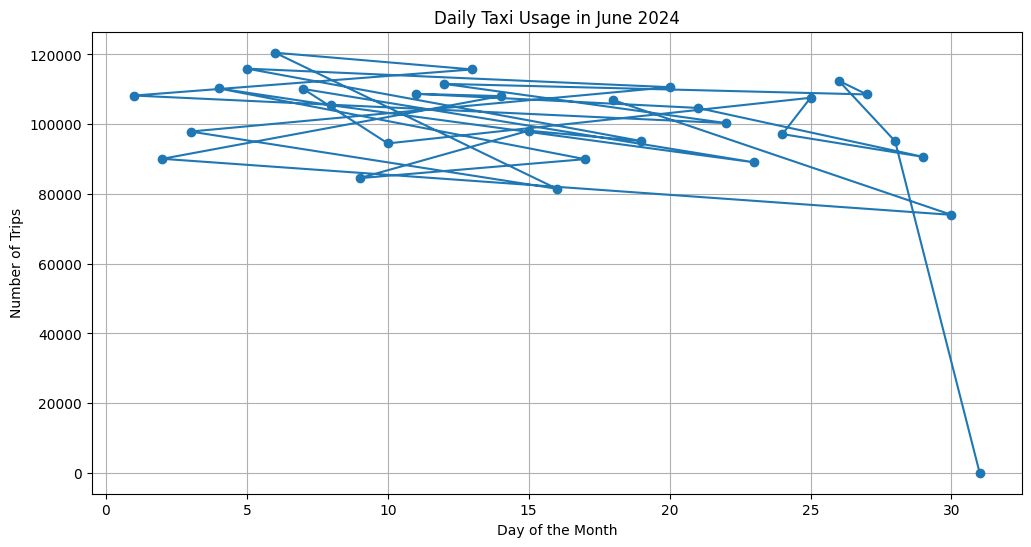

In [13]:
import matplotlib.pyplot as plt

# Convert the daily trends DataFrame to Pandas for visualization
df_daily_pd = df_daily_trends.toPandas()

# Plotting daily taxi usage trends
plt.figure(figsize=(12, 6))
plt.plot(df_daily_pd['day_of_month'], df_daily_pd['total_trips'], marker='o')
plt.title('Daily Taxi Usage in June 2024')
plt.xlabel('Day of the Month')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show()
